# RNN Training

In [ ]:
# download dependencies:
#   * glove embedding (800mb) https://nlp.stanford.edu/projects/glove/
#   * 50,000 imdb movie reviews (80mb) https://ai.stanford.edu/~amaas/data/sentiment/
#   * code for parsing the downloaded data
#   * pretrained neural network
!curl -L "https://raw.githubusercontent.com/pdabacus/ma792/main/download.sh" -o "download.sh"
!bash download.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3181  100  3181    0     0  26073      0 --:--:-- --:--:-- --:--:-- 26073
downloading imdb dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  33.9M      0  0:00:02  0:00:02 --:--:-- 33.9M
extracting imdb dataset to aclImdb/
removing unneeded train/unsup directory
Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import glove
import imdb

glove_embedding = glove.GloVe("glove/glove.6B.100d.txt")
reviews = imdb.IMDB("imdb/")

building word embedding from glove/glove.6B.100d.txt
built embedding of 400000 word vectors each of length 100
preprocessing reviews from imdb//train/pos
[********************] 12500/12500
preprocessing reviews from imdb//test/pos
[********************] 12500/12500
preprocessing reviews from imdb//train/neg
[********************] 12500/12500
preprocessing reviews from imdb//test/neg
[********************] 12500/12500


length of positive reviews:
  mean:  118.891480
  std:   92.470529
  count: 25000


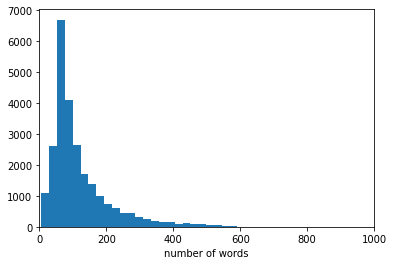

length of negative reviews:
  mean:  115.247520
  std:   84.181243
  count: 25000


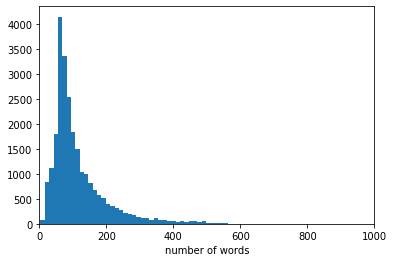

In [ ]:

pos = np.array([len(r) for r in reviews._pos])
neg = np.array([len(r) for r in reviews._neg])

print("length of positive reviews:")
print("  mean:  %.6f" % np.mean(pos))
print("  std:   %.6f" % np.std(pos))
print("  count: %d" % len(pos))
plt.hist(pos, bins=60)
plt.xlim(0, 1000)
plt.xlabel("number of words")
plt.show()

print("length of negative reviews:")
print("  mean:  %.6f" % np.mean(neg))
print("  std:   %.6f" % np.std(neg))
print("  count: %d" % len(neg))
plt.hist(neg, bins=60)
plt.xlim(0, 1000)
plt.xlabel("number of words")
plt.show()

## Train IMDB Neural Net

In [ ]:
import torch

if torch.cuda.is_available():
    print("using cuda for pytorch")
    device = torch.device("cuda")
else:
    print("using cpu for pytorch")
    device = torch.device("cpu")


using cpu for pytorch


In [ ]:
hyperparams = {
    "review_length": 600,
    "test_percent": 0.10,
    "batch_size": 50,
    "lstm_hiddin_dim": 32,
    "lstm_layers": 2,
    "lstm_dropout": 0.2
}

## Build Testing and Training Dataset

In [ ]:
N = hyperparams["review_length"]

# one hot encode all positive reviews
pos = np.matrix([glove_embedding.encode(review, N) for review in reviews._pos], dtype="int")

# one hot encode all negative reviews
neg = np.matrix([glove_embedding.encode(review, N) for review in reviews._neg], dtype="int")



In [ ]:
# split reviews into test and training
def split_test_train(arr, percent_test):
  N = len(arr)
  N_test = int(N * percent_test)
  test_indices = set(np.random.choice(N, N_test, replace=False))
  train_indices = set(range(N)) - test_indices
  test = arr[list(test_indices),:]
  train = arr[list(train_indices),:]
  return test, train

pos_test, pos_train = split_test_train(pos, hyperparams["test_percent"])
neg_test, neg_train = split_test_train(neg, hyperparams["test_percent"])

X_train = np.concatenate((pos_train,neg_train), axis=0)
Y_train = np.matrix([[1,0]]*len(pos_train) + [[0,1]]*len(neg_train), dtype="int")

X_test = np.concatenate((pos_test,neg_test), axis=0)
Y_test = np.matrix([[1,0]]*len(pos_test) + [[0,1]]*len(neg_test), dtype="int")

In [ ]:
# randomly shuffle reviews for training set
random_indices = np.arange(len(X_train))
np.random.shuffle(random_indices)
X_train = X_train[random_indices]
Y_train = Y_train[random_indices]

# randomly shuffle reviews for testing set
random_indices = np.arange(len(X_test))
np.random.shuffle(random_indices)
X_test = X_test[random_indices]
Y_test = Y_test[random_indices]


In [ ]:
# prepare data for loading in batches
import torch.utils.data

train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))

train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=hyperparams["batch_size"])
test_loader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=hyperparams["batch_size"])

In [ ]:
import torch.nn
import rnn

#instantiate the model
output_dim = 2
model = rnn.HappyAngryRNN(
    hyperparams["review_length"],
    glove_embedding,
    hyperparams["lstm_hiddin_dim"],
    hyperparams["lstm_layers"], 
    hyperparams["lstm_dropout"],
    output_dim
)

#model.load_state_dict(torch.load("happy_angry_rnn.pt"))
model.eval()

HappyAngryRNN(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (sig): Sigmoid()
)

In [ ]:
import torch.optim
import torch.nn

#define optimizer and loss
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

def accuracy(yhat, y):
    pred = torch.argmax(yhat, dim=1)
    actual = torch.argmax(y, dim=1)
    
    correct = (pred == actual).float() 
    acc = correct.sum() / len(correct)
    return acc

# if cuda, copy to gpu
model.to(device)
criterion.to(device)

BCELoss()

In [ ]:
#import torch.autograd
#torch.autograd.set_detect_anomaly(False)

def train(model, loader, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = list()
    epoch_acc = list()
    n = 1
    N = len(loader)
    
    # set the model in training phase
    model.train()
    #hidden = model.zero_hidden(hyperparams["batch_size"])
    
    # train in batches
    for review, label in loader:
        optimizer.zero_grad()
        
        predictions = model(review)
        
        loss = criterion(predictions, label.float())
        acc = accuracy(predictions, label)
        
        loss.backward()
        optimizer.step()

        if n % 20 == 0:
          print("    %3d/%d:   loss: %.6f,   acc: %.6f"% (n, N, loss.item(), acc.item()))
        
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        n += 1 
        
    return epoch_loss, epoch_acc

def test(model, loader, criterion):
    
    # initialize every epoch 
    epoch_loss = list()
    epoch_acc = list()
    n = 1
    N = len(loader)
    
    # set the model in validation phase
    model.eval()
    
    # train in batches
    with torch.no_grad():
        for review, label in loader:    
            predictions = model(review)
            
            loss = criterion(predictions, label.float())
            acc = accuracy(predictions, label)
            if n % 20 == 0:
                print("    %3d/%d:   loss: %.6f,   acc: %.6f"% (n, N, loss.item(), acc.item()))
            
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            n += 1 
        
    return epoch_loss, epoch_acc

In [ ]:
def epoch():
    print("training:")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    print("avg loss:", np.mean(train_loss))
    print("avg acc: ", np.mean(train_acc))

    print("testing:")
    test_loss, test_acc = test(model, test_loader, criterion)
    print("test loss:", np.mean(test_loss))
    print("test acc: ", np.mean(test_acc))
    return np.mean(test_loss)

min_loss = 1.0
for i in range(5):
    print("EPOCH %d" % (i+1))
    valid_loss = epoch()
    print("#"*40)
    print()
    
    if valid_loss < min_loss:
        min_loss = valid_loss
        torch.save(model.state_dict(), "happy_angry_rnn.pt")


EPOCH 1
training:
     20/900:   loss: 0.679656,   acc: 0.660000
     40/900:   loss: 0.686402,   acc: 0.660000
     60/900:   loss: 0.683511,   acc: 0.520000
     80/900:   loss: 0.654089,   acc: 0.640000
    100/900:   loss: 0.557605,   acc: 0.760000
    120/900:   loss: 0.760341,   acc: 0.440000
    140/900:   loss: 0.606761,   acc: 0.660000
    160/900:   loss: 0.703494,   acc: 0.640000
    180/900:   loss: 0.577904,   acc: 0.700000
    200/900:   loss: 0.465519,   acc: 0.780000
    220/900:   loss: 0.624810,   acc: 0.700000
    240/900:   loss: 0.600002,   acc: 0.660000
    260/900:   loss: 0.589345,   acc: 0.680000
    280/900:   loss: 0.560773,   acc: 0.740000
    300/900:   loss: 0.629560,   acc: 0.660000
    320/900:   loss: 0.534852,   acc: 0.780000
    340/900:   loss: 0.603235,   acc: 0.740000
    360/900:   loss: 0.740912,   acc: 0.520000
    380/900:   loss: 0.542613,   acc: 0.740000
    400/900:   loss: 0.560866,   acc: 0.700000
    420/900:   loss: 0.627532,   acc: 0.62

## test model

In [ ]:
model.predict("this song is very good. i would listen to it again. best song ever.")

{'negative': 0.11770405620336533, 'positive': 0.8868173956871033}